## Redundancy Hyperparams

### Vector Database

In [1]:
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key="pcsk_39X7W5_3wjJB2qbiri92uQNSN1K2ubxwTrPYTvZWqCGqmf66JCRuWY1iH4gayAGy3mzEos")

In [2]:
import chromadb
import numpy as np

# Initialize ChromaDB (Persistent storage)
chroma_client = chromadb.PersistentClient(path="./chroma_db")

# Create or get the collection
collection = chroma_client.get_or_create_collection(name="submissions_collection")

In [3]:
import pandas as pd

df = pd.read_csv('activity(1).csv')

# Convert column to list, ensuring all values are strings and handling NaNs
data_list = (
    df['activity'].astype(str) + " : " + df['description'].astype(str)
).tolist()

### Function Call for API

In [4]:
import numpy as np

embed_model = pc.inference

def check_and_insert_activity(activity_id, activity_title, activity_description, threshold=0.6):
    """
    Checks if an activity is redundant based on vector similarity and inserts it if not.
    
    Args:
        activity_title (str): Title of the activity.
        activity_description (str): Description of the activity.
        collection (ChromaDB Collection): The vector database collection.
        embed_model: The embedding model (e.g., Llama-text-embed-v2).
        threshold (float): Similarity threshold for redundancy check.
    
    Returns:
        dict: { "redundant": bool, "similar_activities": list of IDs }
    """
    # Combine title and description
    query_text = f"{activity_title} : {activity_description}"
    
    # Embed the query
    query_embedding = embed_model.embed(
        model="llama-text-embed-v2",
        inputs=[query_text],
        parameters={"input_type": "passage"}
    )[0]["values"]

    # Search in ChromaDB
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=10  # Get top 10 similar activities
    )

    # Extract results
    similarities = results["distances"][0]  # ChromaDB returns cosine distance
    activity_ids = results["ids"][0]  # Extract matching IDs

    # Convert cosine distance to similarity (cosine similarity = 1 - distance)
    similar_activity_ids = [
        activity_id for sim, activity_id in zip(similarities, activity_ids) if (1 - sim) > threshold
    ]

    # If redundancy is found, return the similar activity IDs
    if similar_activity_ids:
        return True, similar_activity_ids
    
    # Otherwise, insert the new activity into ChromaDB
    collection.add(
        embeddings=[query_embedding],
        metadatas=[{"text": query_text}],
        ids=[activity_id]
    )

    return False, []

### Elbow for 100

In [5]:
import pandas as pd

df = pd.read_csv('activity(1).csv')[:100]
df.index += 1

In [6]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_redundancies1 = []

for th in thresholds:
    df['redundant'], df['similar_activities'] = zip(*df.apply(lambda row: check_and_insert_activity(str(row.name), row['activity'], row['description'], threshold=th), axis=1))
    
    df["similar_activities"] = df.apply(lambda row: [x for x in row["similar_activities"] if str(x) != str(row.name)], axis=1)
    df["redundant"] = df["similar_activities"].apply(lambda x: False if len(x) == 0 else True)
    
    ss = df['redundant'].sum()
    n_redundancies1.append(ss)
    print(f'{th} done! ({ss})')
    
df.head()

0.2 done! (92)
0.3 done! (84)
0.4 done! (73)
0.5 done! (57)
0.6 done! (28)
0.7 done! (7)
0.8 done! (3)
0.9 done! (2)


,code_pro,wilaya,field,activity,description,redundant,similar_activities
1,P6B3R8CC,Algiers,NaN,Technicien de Maintenance du matériel Prépress...,Le service Prépresse est équipé des machines C...,False,[]
2,LPC2SE3W,Algiers,Services à la personne,معالجة ملفات تأشيرة و خدمات الزبائن,معالجة ملفات تأشيرة وحجز مواعيد والتوجبه الزبا...,False,[]
3,DBX8Y5D7,Batna,"Conseil, Expertise et formation",مستشار مختص بتأشيرات السفر و برامج الهجرة,تقديم استشارات في مجال السفر و الهجرة من أجل م...,False,[]
4,PYC53DLT,Msila,Services à la personne,الرسم بالزيت والرمل,رسم أشخاص وطبيعة و مناظر صحراوية بالزيت والرمل,False,[]
5,TLLSNCC9,Algiers,Services à la personne,Dessinateur projeteur en travaux publics et su...,dessinateur projeteur en travaux publics (bâti...,False,[]


In [7]:
n_redundancies1

[92, 84, 73, 57, 28, 7, 3, 2]

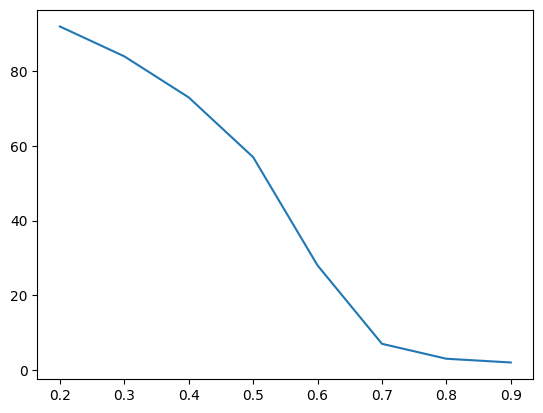

In [12]:
import matplotlib.pyplot as plt

plt.plot(thresholds, n_redundancies1,)

### Elbow for 650

In [16]:
df = pd.read_csv('activity(1).csv')[:650]
df.index += 1

In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_redundancies2 = []

In [18]:
for th in thresholds:
    df['redundant'], df['similar_activities'] = zip(*df.apply(lambda row: check_and_insert_activity(str(row.name), row['activity'], row['description'], threshold=th), axis=1))
    
    df["similar_activities"] = df.apply(lambda row: [x for x in row["similar_activities"] if str(x) != str(row.name)], axis=1)
    df["redundant"] = df["similar_activities"].apply(lambda x: False if len(x) == 0 else True)
    
    ss = df['redundant'].sum()
    n_redundancies2.append(ss)
    print(f'{th} done! ({ss})')
    
df.head()

0.9 done! (9)


,code_pro,wilaya,field,activity,description,redundant,similar_activities
1,P6B3R8CC,Algiers,NaN,Technicien de Maintenance du matériel Prépress...,Le service Prépresse est équipé des machines C...,False,[]
2,LPC2SE3W,Algiers,Services à la personne,معالجة ملفات تأشيرة و خدمات الزبائن,معالجة ملفات تأشيرة وحجز مواعيد والتوجبه الزبا...,False,[]
3,DBX8Y5D7,Batna,"Conseil, Expertise et formation",مستشار مختص بتأشيرات السفر و برامج الهجرة,تقديم استشارات في مجال السفر و الهجرة من أجل م...,False,[]
4,PYC53DLT,Msila,Services à la personne,الرسم بالزيت والرمل,رسم أشخاص وطبيعة و مناظر صحراوية بالزيت والرمل,False,[]
5,TLLSNCC9,Algiers,Services à la personne,Dessinateur projeteur en travaux publics et su...,dessinateur projeteur en travaux publics (bâti...,False,[]


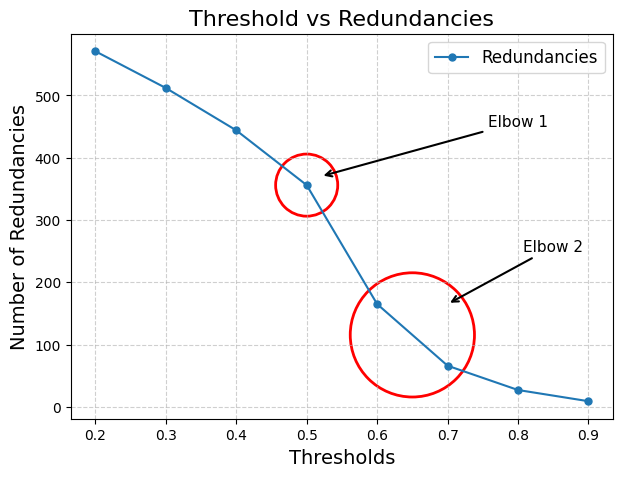

In [58]:
plt.figure(figsize=(7,5))

# Plot with markers
plt.plot(thresholds, n_redundancies2, marker='o', linestyle='-', markersize=5, label='Redundancies')

# Draw circles around key points
plt.scatter(0.5, 356, s=2000, facecolors='none', edgecolors='red', linewidth=2)  # First circle
plt.scatter(0.65, (165+66)/2, s=8000, facecolors='none', edgecolors='red', linewidth=2)  # Larger second circle

# Add arrows pointing to the circles (adjusted positions)
plt.annotate('Elbow 1', xy=(0.52, 370), xytext=(0.8, 450),
             fontsize=11, ha='center', arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

plt.annotate('Elbow 2', xy=(0.7, 165), xytext=(0.85, 250),
             fontsize=11, ha='center', arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

# Labels and grid
plt.xlabel("Thresholds", fontsize=14)
plt.ylabel("Number of Redundancies", fontsize=14)
plt.title("Threshold vs Redundancies", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=12)
plt.savefig('elbow_method.png')
plt.show()